In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
# from transformers import AdamW
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/stefan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1.1 - Create a simple model that analyzes text using an artificial neural network (ANN)

In [68]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace(r'[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace(r'\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_.loc[len(df_)] = {
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent),
        }
    return data

In [70]:
# class SimpleANN(nn.Module):
#     def __init__(self, input_dim):
#         super(SimpleANN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(64, 2)  # 2 classes: 0 or 1

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# Define a simple ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, 2)  # 2 classes: negative (0) or positive (1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [112]:
# get data, pre-process and split
data = pd.read_csv("./amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


model = SimpleANN(train_x_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

train_losses = []
train_accuracies = []

epochs = 10
# Training loop
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(validation_x_tensor)
        val_loss = criterion(val_outputs, validation_y_tensor)
        preds = torch.argmax(val_outputs, dim=1)
        acc = (preds == validation_y_tensor).float().mean()
    
    # accuracy = correct / total
    # avg_loss = total_loss / len(train_loader) 
    # train_losses.append(avg_loss)
    # train_accuracies.append(accuracy)

    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Acc: {acc.item():.4f}")
    train_losses.append(loss.item())
    train_accuracies.append(acc.item())

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(validation_x_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)

    acc = accuracy_score(validation_y_tensor, predicted_classes)
    print(f"\nValidation Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(validation_y_tensor, predicted_classes))

Epoch 1, Train Loss: 0.6953, Val Acc: 0.4700
Epoch 2, Train Loss: 0.6716, Val Acc: 0.7500
Epoch 3, Train Loss: 0.6267, Val Acc: 0.8200
Epoch 4, Train Loss: 0.5633, Val Acc: 0.8200
Epoch 5, Train Loss: 0.4864, Val Acc: 0.8000
Epoch 6, Train Loss: 0.4024, Val Acc: 0.8000
Epoch 7, Train Loss: 0.3184, Val Acc: 0.8100
Epoch 8, Train Loss: 0.2407, Val Acc: 0.8200
Epoch 9, Train Loss: 0.1743, Val Acc: 0.8100
Epoch 10, Train Loss: 0.1215, Val Acc: 0.8000

Validation Accuracy: 0.8000

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.80        47
           1       0.85      0.75      0.80        53

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



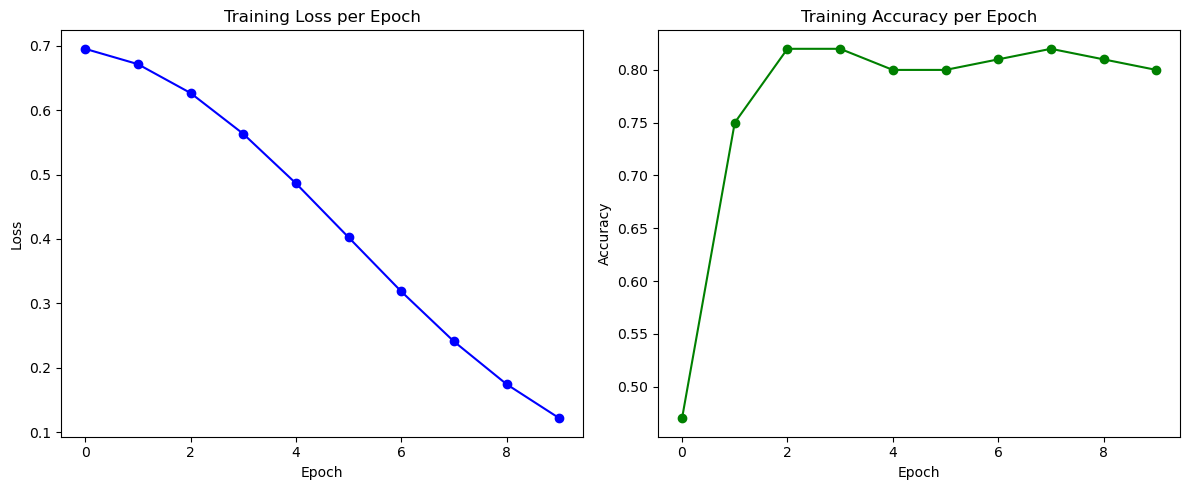

In [114]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [116]:
# get data, pre-process and split
data = pd.read_csv("./amazon_cells_labelled_LARGE_25k.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


In [118]:
data

,Sentence,Class,index
0,"i've read this book with much expectation, it ...",0,0
1,love it...very touch.it's to bad that in the d...,1,1
2,the creepiest book i've ever read! it's a cree...,1,2
3,"it starts off a bit slow, but once the product...",1,3
4,"as good as this book may be, the print quality...",0,4
...,...,...,...
24995,"no chance this will fit on a """"normal"""" sized ...",0,24995
24996,this is a a good view on how computers wwork a...,1,24996
24997,"laughable lyrics, music just slightly better, ...",0,24997
24998,la camisa es % original y demaciado comoda la ...,1,24998


In [122]:

model = SimpleANN(train_x_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

train_losses = []
train_accuracies = []

epochs = 10
# Training loop
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(validation_x_tensor)
        val_loss = criterion(val_outputs, validation_y_tensor)
        preds = torch.argmax(val_outputs, dim=1)
        acc = (preds == validation_y_tensor).float().mean()
    
    # accuracy = correct / total
    # avg_loss = total_loss / len(train_loader) 
    # train_losses.append(avg_loss)
    # train_accuracies.append(accuracy)

    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Acc: {acc.item():.4f}")
    train_losses.append(loss.item())
    train_accuracies.append(acc.item())

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(validation_x_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)

    acc = accuracy_score(validation_y_tensor, predicted_classes)
    print(f"\nValidation Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(validation_y_tensor, predicted_classes))

Epoch 1, Train Loss: 0.7103, Val Acc: 0.8268
Epoch 2, Train Loss: 0.6721, Val Acc: 0.7096
Epoch 3, Train Loss: 0.6259, Val Acc: 0.6780
Epoch 4, Train Loss: 0.5723, Val Acc: 0.6932
Epoch 5, Train Loss: 0.5134, Val Acc: 0.7220
Epoch 6, Train Loss: 0.4518, Val Acc: 0.7560
Epoch 7, Train Loss: 0.3895, Val Acc: 0.8064
Epoch 8, Train Loss: 0.3288, Val Acc: 0.8396
Epoch 9, Train Loss: 0.2728, Val Acc: 0.8600
Epoch 10, Train Loss: 0.2239, Val Acc: 0.8704

Validation Accuracy: 0.8704

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1011
           1       0.86      0.93      0.90      1489

    accuracy                           0.87      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.87      0.87      0.87      2500



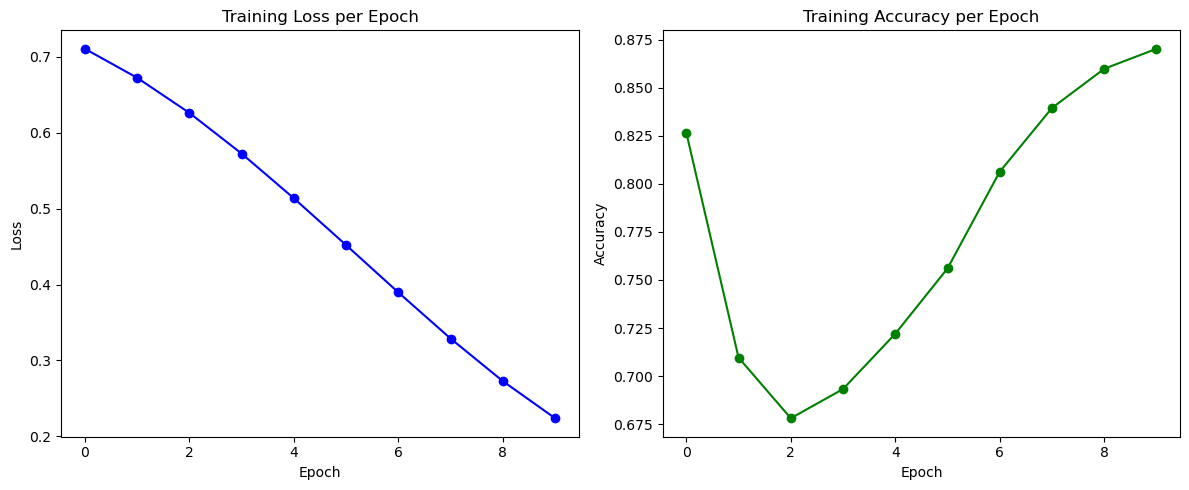

In [124]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [128]:
# get data, pre-process and split
# data = pd.read_csv("./amazon_cells_labelled.txt", delimiter='\t', header=None)
# # data = pd.read_csv("./amazon_cells_labelled_LARGE_25k.txt", delimiter='\t', header=None)

# data.columns = ['Sentence', 'Class']
# data['index'] = data.index                                          # add new column index
# columns = ['index', 'Class', 'Sentence']
# data = preprocess_pandas(data, columns) # pre-process

stop_words = set(stopwords.words('english'))


def preprocess(sentence):
    tokens = word_tokenize(sentence.lower())
    return [w for w in tokens if w.isalpha() and w not in stop_words]

data['Tokens'] = data['Sentence'].apply(preprocess)


training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

embedding_dim = 100
w2v_model = Word2Vec(sentences=data['Tokens'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

def sentence_to_vec(tokens, model, dim):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

data['Embedding'] = data['Tokens'].apply(lambda tokens: sentence_to_vec(tokens, w2v_model, embedding_dim))
# data




In [146]:
# vectorize data using TFIDF and transform for PyTorch for scalability
# word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
# training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
# training_data = training_data.todense()                             # convert to dense matrix for Pytorch
# vocab_size = len(word_vectorizer.vocabulary_)
# validation_data = word_vectorizer.transform(validation_data)
# validation_data = validation_data.todense()
# train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
# train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
# validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
# validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

X = np.vstack(data['Embedding'].values)
y = data['Class'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=0)

train_x_tensor = torch.tensor(X_train, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train, dtype=torch.long)
validation_x_tensor = torch.tensor(X_val, dtype=torch.float32)
validation_y_tensor = torch.tensor(y_val, dtype=torch.long)


model = SimpleANN(train_x_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

train_losses = []
train_accuracies = []

# Training loop
for epoch in range(25):
    model.train()
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(validation_x_tensor)
        val_loss = criterion(val_outputs, validation_y_tensor)
        preds = torch.argmax(val_outputs, dim=1)
        acc = (preds == validation_y_tensor).float().mean()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Acc: {acc.item():.4f}")

    # print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Acc: {acc.item():.4f}")
    train_losses.append(loss.item())
    train_accuracies.append(acc.item())

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(validation_x_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)

    acc = accuracy_score(validation_y_tensor, predicted_classes)
    print(f"\nValidation Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(validation_y_tensor, predicted_classes))

Epoch 1, Train Loss: 0.6725, Val Acc: 0.5956
Epoch 2, Train Loss: 0.6830, Val Acc: 0.5968
Epoch 3, Train Loss: 0.6449, Val Acc: 0.6688
Epoch 4, Train Loss: 0.6525, Val Acc: 0.6336
Epoch 5, Train Loss: 0.6299, Val Acc: 0.6144
Epoch 6, Train Loss: 0.6186, Val Acc: 0.6156
Epoch 7, Train Loss: 0.6160, Val Acc: 0.6292
Epoch 8, Train Loss: 0.5986, Val Acc: 0.6708
Epoch 9, Train Loss: 0.5857, Val Acc: 0.7080
Epoch 10, Train Loss: 0.5820, Val Acc: 0.7044
Epoch 11, Train Loss: 0.5677, Val Acc: 0.6820
Epoch 12, Train Loss: 0.5563, Val Acc: 0.6716
Epoch 13, Train Loss: 0.5534, Val Acc: 0.6924
Epoch 14, Train Loss: 0.5420, Val Acc: 0.7192
Epoch 15, Train Loss: 0.5354, Val Acc: 0.7312
Epoch 16, Train Loss: 0.5341, Val Acc: 0.7200
Epoch 17, Train Loss: 0.5254, Val Acc: 0.7112
Epoch 18, Train Loss: 0.5259, Val Acc: 0.7096
Epoch 19, Train Loss: 0.5228, Val Acc: 0.7292
Epoch 20, Train Loss: 0.5201, Val Acc: 0.7336
Epoch 21, Train Loss: 0.5220, Val Acc: 0.7328
Epoch 22, Train Loss: 0.5181, Val Acc: 0.71

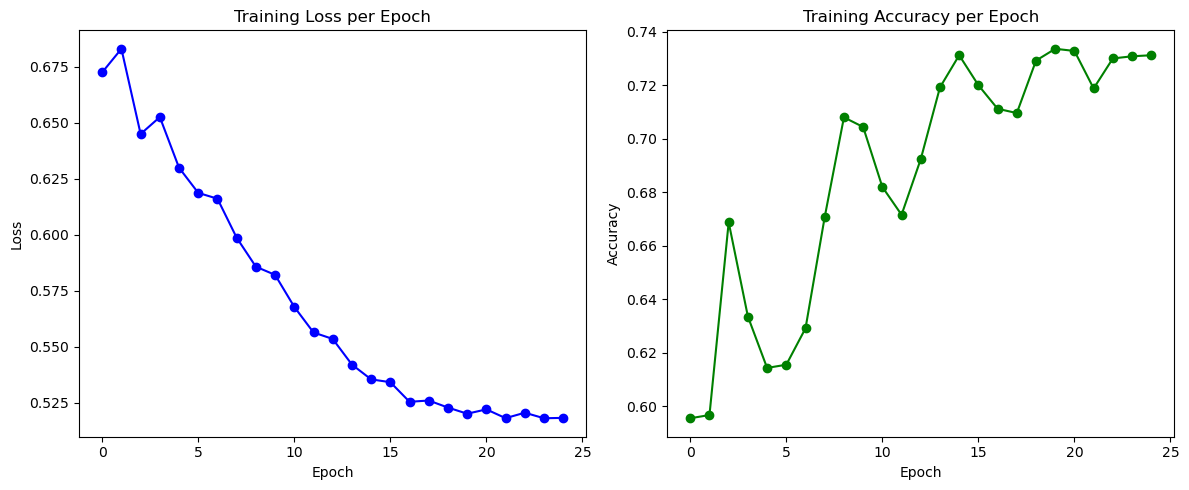

In [148]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [150]:
data

,Sentence,Class,index,Tokens,Embedding
0,"i've read this book with much expectation, it ...",0,0,"[read, book, much, expectation, boring, book]","[-0.79995686, 0.7041101, 0.4509735, -0.3351029..."
1,love it...very touch.it's to bad that in the d...,1,1,"[love, bad, dvd, description, mention, subtitles]","[-0.43199575, 0.42107192, 0.13743545, -0.04355..."
2,the creepiest book i've ever read! it's a cree...,1,2,"[creepiest, book, ever, read, creepy, one, cre...","[-0.6341599, 0.6672998, 0.36109167, -0.3675575..."
3,"it starts off a bit slow, but once the product...",1,3,"[starts, bit, slow, product, placement, jokes,...","[-0.26384538, 0.31760633, 0.099848464, 0.04198..."
4,"as good as this book may be, the print quality...",0,4,"[good, book, may, print, quality, bad, read, z...","[-0.5230639, 0.4567893, 0.12444962, -0.0832887..."
...,...,...,...,...,...
24995,"no chance this will fit on a """"normal"""" sized ...",0,24995,"[chance, fit, normal, sized, head, mom, huge, ...","[-0.25566, 0.36566022, 0.11781005, 0.057276033..."
24996,this is a a good view on how computers wwork a...,1,24996,"[good, view, computers, wwork, fix, things, tr...","[-0.26703534, 0.25212777, 0.0346945, -0.035062..."
24997,"laughable lyrics, music just slightly better, ...",0,24997,"[laughable, lyrics, music, slightly, better, t...","[-0.42455855, 0.52282125, 0.15996337, -0.14102..."
24998,la camisa es % original y demaciado comoda la ...,1,24998,"[la, camisa, es, original, demaciado, comoda, ...","[-0.17660612, 0.25277677, 0.08020092, 0.000821..."


## Task 1.2 - Transformers Implementation

In [57]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

In [169]:
data = pd.read_csv("./amazon_cells_labelled.txt", delimiter="\t", header=None)
data.columns = ['sentence', 'label']

In [175]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Tokenize sentences
encodings = tokenizer(
    data['sentence'].tolist(),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:
class SimpleANN_2(nn.Module):
    def __init__(self, input_dim):
        super(SimpleANN_2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # 2 classes: 0 or 1

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [179]:
class AmazonDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

dataset = AmazonDataset(encodings, data['label'].tolist())

# Train-validation split
from torch.utils.data import random_split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

  3%|███▊                                                                                                                                          | 3/113 [00:05<03:11,  1.74s/it]

In [54]:
from sklearn.metrics import accuracy_score

model.eval()
preds, true = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        pred_labels = torch.argmax(logits, dim=1)
        preds.extend(pred_labels.cpu().numpy())
        true.extend(inputs['labels'].cpu().numpy())

acc = accuracy_score(true, preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.9500


,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0
